# Training RNN on Rowing Skeletons
The purpose of this notebook is to train an RNN on the rowing skeleton data that Emelie generated. After training the RNN, we will classify the ability of the rower using the RNN activations.

## Imports

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
def set_seed(seed_value=101):
    """Set seed for reproducibility."""
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

## Create dataset

In [4]:
drive_locations = [
    './data/PR1_vid1/PR1_coordinates_v_a_angle.csv',
    './data/PR1_vid2/PR2_1_2_coordinates_v_a_angle.csv',
    './data/PR2_vid1/PR2_coordinates_v_a_angle.csv',
    './data/PR2_vid2/PR2_2_coordinates_v_a_angle.csv',
    './data/PR3_vid1/PR2_3_1_coordinates_v_a_angle.csv',
    './data/PR3_vid21/PR2_3_2_coordinates_v_a_angle.csv',
]

pr_labels = [
    'PR1',
    'PR1',
    'PR2',
    'PR2',
    'PR3',
    'PR3',
]

In [5]:
def drop_columns(df):
    # Find columns that do not have exactly 3 underscores
    cols_to_drop = [col for col in df.columns if col.count('_') != 2 or 'coco' in col]

    # Drop these columns
    df.drop(columns=cols_to_drop, inplace=True)

    return df

def all_lists_identical(list_of_lists):
    # Check if list_of_lists is empty or contains only one list
    if not list_of_lists or len(list_of_lists) == 1:
        return True

    # Take the first list as the reference
    first_list = list_of_lists[0]

    # Compare each subsequent list with the first list
    for lst in list_of_lists[1:]:
        if lst != first_list:
            return False

    return True

def equalize_df_lengths(df_list):
    # Determine the length of the shortest DataFrame
    min_length = min(len(df) for df in df_list)

    # Modify each DataFrame to match the shortest length
    for i in range(len(df_list)):
        # Truncate if longer
        if len(df_list[i]) > min_length:
            df_list[i] = df_list[i].iloc[:min_length]
        # Extend if shorter
        elif len(df_list[i]) < min_length:
            # Create a DataFrame with NaNs to append
            additional_rows = min_length - len(df_list[i])
            columns = df_list[i].columns
            df_to_append = pd.DataFrame([[pd.NA] * len(columns)] * additional_rows, columns=columns)
            df_list[i] = pd.concat([df_list[i], df_to_append], ignore_index=True)

    return df_list

In [6]:
csv_df = [drop_columns(pd.read_csv(i))for i in drive_locations]

In [7]:
csv_df_column_names = [list(i.columns) for i in csv_df]
all_lists_identical(csv_df_column_names)

True

In [8]:
csv_df = equalize_df_lengths(csv_df)

In [9]:
csv_df_lens = [len(i) for i in csv_df]
csv_df_lens

[328, 328, 328, 328, 328, 328]

In [10]:
np_key_points = np.stack([i.to_numpy() for i in csv_df], axis=0)
np_key_points.shape

(6, 328, 72)

In [11]:
n, T, f = np_key_points.shape

In [12]:
# Generate a random vector of length 20 for each dataset
random_vectors = np.random.rand(n, 20)

# Replicate each vector T times within its dataset
embedding_vectors = np.repeat(random_vectors[:, np.newaxis, :], T, axis=1)

# new_array is now of shape (n, T, 20)
# Each dataset has its own random vector repeated T times
embedding_vectors.shape

(6, 328, 20)

## Train RNN

In [13]:
class TimeSeriesRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesRNN, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

    def rates(self, x):
        out, _ = self.rnn(x)
        return out

In [14]:
def get_incremental_data(epoch, max_data_size, step_size, embedding_vectors_tensor, np_key_points_tensor):
    # Increase data size with each step until the maximum size is reached
    data_size = min(int(step_size * epoch + 1), max_data_size)
    return embedding_vectors_tensor[:data_size], np_key_points_tensor[:data_size]

In [15]:
# Initialize the model, loss function, and optimizer
input_size = 20
hidden_size = 200  # Example value, needs tuning
output_size = f   # Number of features in np_key_points

model = TimeSeriesRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())

# Convert data to PyTorch tensors
embedding_vectors_tensor = torch.tensor(embedding_vectors, dtype=torch.float32)
np_key_points_tensor = torch.tensor(np_key_points, dtype=torch.float32)

# Curriculum learning
num_epochs = 5000
max_data_size = len(embedding_vectors_tensor)
step_size = 0.002
min_loss = float('inf')
min_epoch = None

In [16]:
losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()

    # Get the subset of data for the current epoch
    current_emb_vectors, current_key_points = get_incremental_data(epoch, max_data_size, step_size, embedding_vectors_tensor, np_key_points_tensor)

    # Forward pass with the current subset of data
    output = model(current_emb_vectors)
    loss = criterion(output, current_key_points)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    losses.append((epoch, loss.item(), current_emb_vectors.shape[0],))

    # Check if the current loss is the lowest
    if loss.item() < min_loss and epoch > int(max_data_size/step_size + 10):
        min_loss = loss.item()
        min_epoch = epoch
        torch.save(model.state_dict(), './RNN/best_model.pth')

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.5f}')

 10%|█         | 501/5000 [00:54<06:35, 11.37it/s]

Epoch [500/5000], Loss: 0.00757


 20%|██        | 1001/5000 [01:52<07:23,  9.01it/s]

Epoch [1000/5000], Loss: 0.01440


 30%|███       | 1501/5000 [02:56<08:59,  6.48it/s]

Epoch [1500/5000], Loss: 0.00121


 40%|████      | 2001/5000 [03:58<05:49,  8.58it/s]

Epoch [2000/5000], Loss: 0.00077


 50%|█████     | 2501/5000 [05:05<06:35,  6.31it/s]

Epoch [2500/5000], Loss: 0.00088


 60%|██████    | 3001/5000 [06:13<04:10,  7.99it/s]

Epoch [3000/5000], Loss: 0.00163


 70%|███████   | 3501/5000 [07:24<03:02,  8.21it/s]

Epoch [3500/5000], Loss: 0.00152


 80%|████████  | 4001/5000 [08:33<02:07,  7.81it/s]

Epoch [4000/5000], Loss: 0.00130


 90%|█████████ | 4501/5000 [09:42<01:26,  5.78it/s]

Epoch [4500/5000], Loss: 0.00131


100%|██████████| 5000/5000 [10:50<00:00,  7.69it/s]

Epoch [5000/5000], Loss: 0.00125


In [17]:
print(f'Minimum Loss: {min_loss:.5f}')
print(f'Minimum Loss Epoch: {min_epoch}')

Minimum Loss: 0.00105
Minimum Loss Epoch: 4990


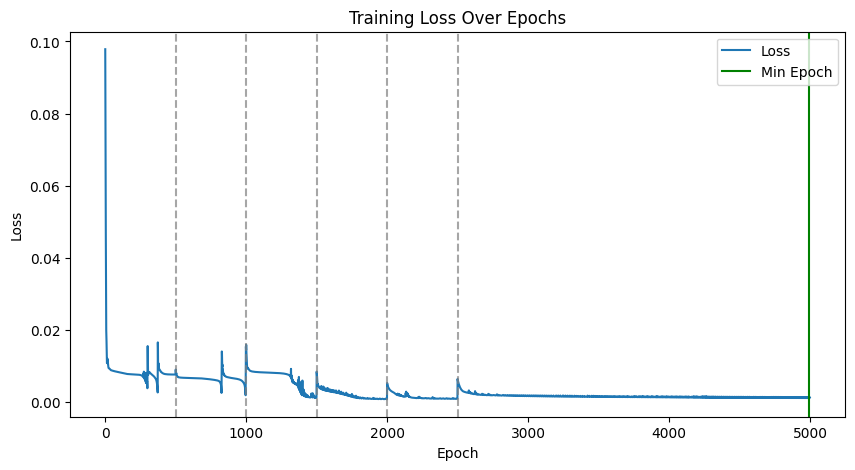

In [18]:
# Unpack epoch, loss, and data size from the losses list
epochs, loss_values, data_sizes = zip(*losses)

# Plotting the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, label='Loss')

# Adding vertical lines for increments in data size
prev_data_size = data_sizes[0]
for epoch, data_size in zip(epochs, data_sizes):
    if data_size != prev_data_size:
        plt.axvline(x=epoch, color='gray', linestyle='--', alpha=0.7)
        prev_data_size = data_size

# Marking the minimum epoch
plt.axvline(x=min_epoch, color='green', linestyle='-', label='Min Epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.savefig('./RNN/loss_plot.png')
plt.show()

## RNN analysis

In [19]:
model.load_state_dict(torch.load('./RNN/best_model.pth'))
model.eval()

TimeSeriesRNN(
  (rnn): GRU(20, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=72, bias=True)
)

In [20]:
output = model(embedding_vectors_tensor)
output = output.detach().numpy()

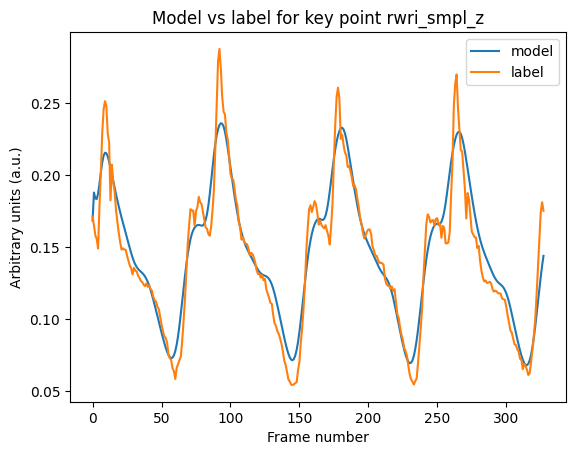

In [21]:
key_point_name = csv_df_column_names[0][65]

plt.plot(output[0, :, 65], label='model')
plt.plot(np_key_points_tensor[0, :, 65], label='label')
plt.title(f"Model vs label for key point {key_point_name}")
plt.xlabel('Frame number')
plt.ylabel('Arbitrary units (a.u.)')
plt.legend()
plt.savefig('./RNN/model_vs_label.png')
plt.show()

In [22]:
labels = np.array([0, 0, 1, 1, 2, 2])

model_rates = model.rates(embedding_vectors_tensor)
model_rates = model_rates.detach().numpy()
model_rates.shape

(6, 328, 200)

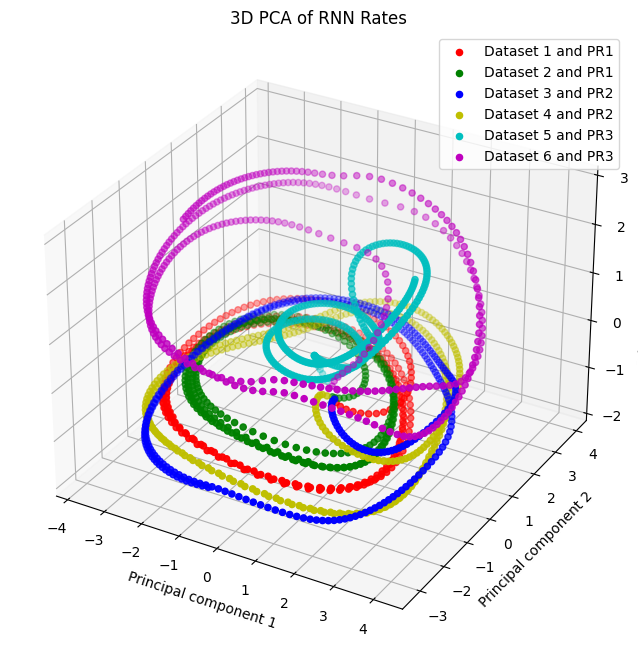

In [23]:
# Reshape the data for PCA
n_datasets, n_timepoints, n_features = model_rates.shape
reshaped_rates = model_rates.reshape(n_datasets * n_timepoints, n_features)

# Apply PCA
pca = PCA(n_components=3)
rates_pca = pca.fit_transform(reshaped_rates)

# Reshape the transformed data back for plotting
rates_pca_reshaped = rates_pca.reshape(n_datasets, n_timepoints, 3)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each dataset in a different color
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i in range(n_datasets):
    ax.scatter(rates_pca_reshaped[i, :, 0],  # PCA component 1
               rates_pca_reshaped[i, :, 1],  # PCA component 2
               rates_pca_reshaped[i, :, 2],  # PCA component 3
               c=colors[i], label=f'Dataset {i+1} and {pr_labels[i]}')

ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3')
ax.legend()
plt.title('3D PCA of RNN Rates')
plt.savefig('./RNN/pca_3d.png')
plt.show()


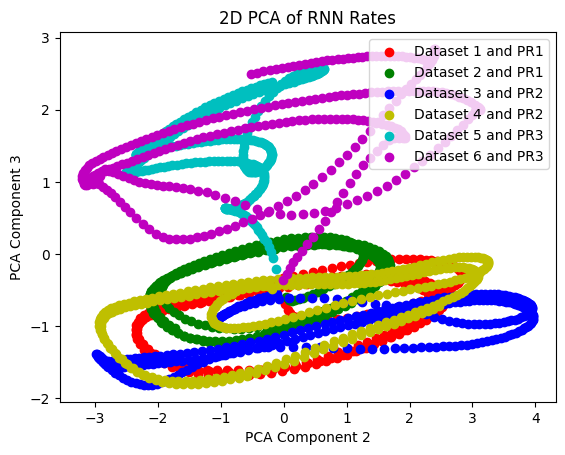

In [24]:
# Plot each dataset in a different color
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i in range(n_datasets):
    plt.scatter(rates_pca_reshaped[i, :, 1],  # PCA component 2
               rates_pca_reshaped[i, :, 2],  # PCA component 3
               c=colors[i], label=f'Dataset {i+1} and {pr_labels[i]}')

plt.xlabel('PCA Component 2')
plt.ylabel('PCA Component 3')
plt.legend()
plt.title('2D PCA of RNN Rates')
plt.savefig('./RNN/pca_2d.png')
plt.show()

In [25]:
def flatten_rates_and_labels(model_rates, labels):
    flattened_labels = []
    flattened_rates = []

    for i in range(labels.shape[0]):
        for t in range(model_rates.shape[1]):
            flattened_labels.append(labels[i])
            flattened_rates.append(model_rates[i, t, :])

    flattened_labels = np.stack(flattened_labels)
    flattened_rates = np.stack(flattened_rates)

    return flattened_rates, flattened_labels

In [26]:
def leave_one_dataset_out(model_rates, labels):
    testing_accuracies = []

    for i in range(model_rates.shape[0]):
        # Leave one dataset out for testing
        model_rates_train = np.delete(model_rates, i, axis=0)
        labels_train = np.delete(labels, i, axis=0)

        model_rates_test = model_rates[i:i+1]
        labels_test = labels[i:i+1]

        # Flatten rates and labels
        X_train, y_train = flatten_rates_and_labels(model_rates_train, labels_train)
        X_test, y_test = flatten_rates_and_labels(model_rates_test, labels_test)

        # Initialize and train the classifier
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)

        # Store the testing accuracy
        testing_accuracy = clf.score(X_test, y_test)
        testing_accuracies.append(testing_accuracy)

    return testing_accuracies

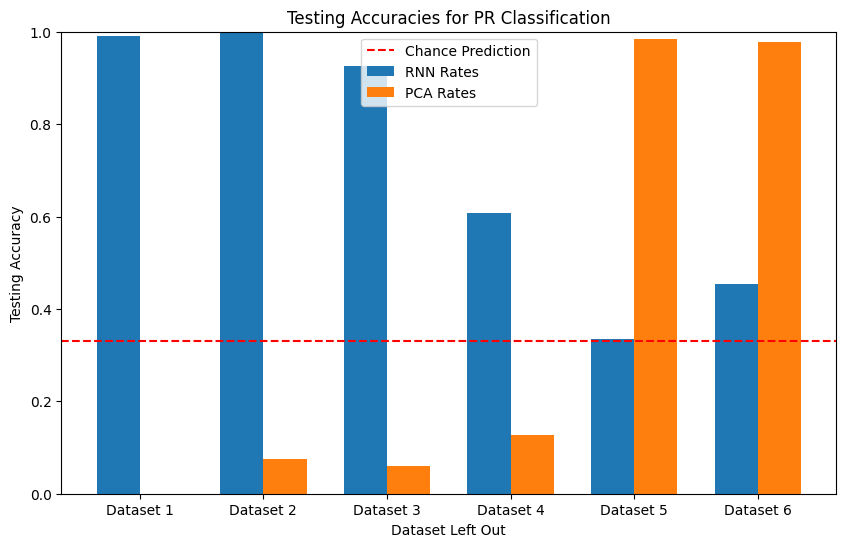

In [27]:
# Calculate testing accuracies for each dataset using RNN rates
testing_accuracies_rnn = leave_one_dataset_out(model_rates, labels)

# Calculate testing accuracies for each dataset using PCA rates
testing_accuracies_pca = leave_one_dataset_out(rates_pca_reshaped, labels)

# Number of datasets
n_datasets = len(testing_accuracies_rnn)

# Create plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(n_datasets)

# Plotting both bars
plt.bar(index, testing_accuracies_rnn, bar_width, label='RNN Rates')
plt.bar(index + bar_width, testing_accuracies_pca, bar_width, label='PCA Rates')

plt.xlabel('Dataset Left Out')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracies for PR Classification')
plt.xticks(index + bar_width / 2, [f'Dataset {i+1}' for i in range(n_datasets)])
plt.ylim([0, 1])  # Accuracy ranges from 0 to 1
plt.axhline(y=0.33, color='r', linestyle='--', label='Chance Prediction')
plt.legend()
plt.savefig('./RNN/pr_classification_without_time.png')
plt.show()

In [28]:
def create_windowed_data(rates, labels, time_point, window_size=7):
    # Calculate the start and end of the window
    start = max(time_point - window_size // 2, 0)
    end = min(time_point + window_size // 2 + 1, rates.shape[1])

    # Slice the window for all datasets
    windowed_rates = rates[:, start:end, :]

    windowed_rates, windowed_labels = flatten_rates_and_labels(windowed_rates, labels)
    return windowed_rates, windowed_labels

def leave_one_dataset_out_cross_validation(model_rates, labels, window_size=7):
    n_datasets, n_timepoints, _ = model_rates.shape
    avg_testing_accuracies = []
    std_devs = []

    for time_point in tqdm(range(n_timepoints)):
        testing_accuracies = []

        for i in range(n_datasets):
            # Leave one dataset out for testing
            model_rates_train = np.delete(model_rates, i, axis=0)
            labels_train = np.delete(labels, i, axis=0)

            model_rates_test = model_rates[i:i+1]
            labels_test = labels[i:i+1]

            # Create windowed data
            X_train, y_train = create_windowed_data(model_rates_train, labels_train, time_point, window_size)
            X_test, y_test = create_windowed_data(model_rates_test, labels_test, time_point, window_size)

            # Initialize and train the classifier
            clf = LogisticRegression(max_iter=1000)
            clf.fit(X_train, y_train)

            # Store the testing accuracy
            testing_accuracy = clf.score(X_test, y_test)
            testing_accuracies.append(testing_accuracy)

        # Calculate average and standard deviation of testing accuracies
        avg_testing_accuracies.append(np.mean(testing_accuracies))
        std_devs.append(np.std(testing_accuracies))

    return avg_testing_accuracies, std_devs

100%|██████████| 328/328 [00:12<00:00, 26.49it/s]


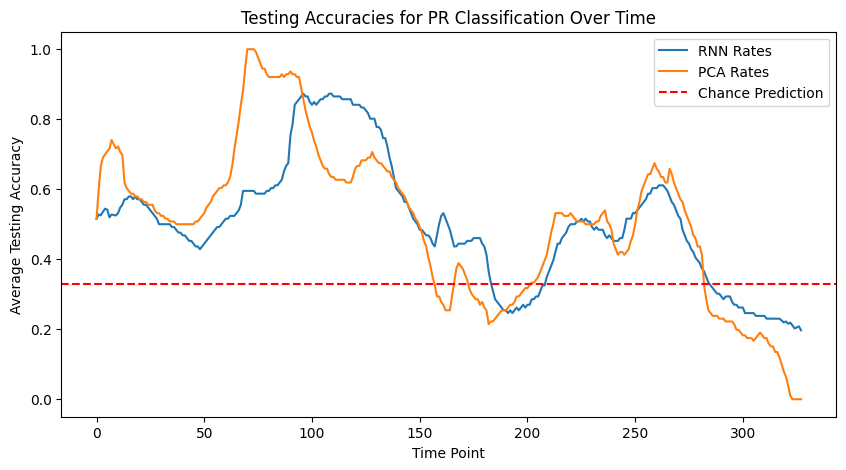

In [29]:
window_size = 21

avg_testing_accuracies_rnn, _ = leave_one_dataset_out_cross_validation(model_rates, labels, window_size=window_size)
avg_testing_accuracies_pca, _ = leave_one_dataset_out_cross_validation(rates_pca_reshaped, labels, window_size=window_size)

# Number of time points
n_timepoints = len(avg_testing_accuracies_rnn)

# Create plot
plt.figure(figsize=(10, 5))
plt.plot(range(n_timepoints), avg_testing_accuracies_rnn, label='RNN Rates')
plt.plot(range(n_timepoints), avg_testing_accuracies_pca, label='PCA Rates')

plt.xlabel('Time Point')
plt.ylabel('Average Testing Accuracy')
plt.title('Testing Accuracies for PR Classification Over Time')
plt.legend()

# Draw a horizontal line at 0.33 for chance prediction
plt.axhline(y=0.33, color='r', linestyle='--', label='Chance Prediction')
plt.legend()
plt.savefig('./RNN/pr_classification_over_time.png')
plt.show()